In [ ]:
pip install -U https://github.com/PythonOT/POT/archive/master.zip # with --user for user install (no root)

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     / 2.7 MB 1.5 MB/s
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
    Preparing wheel metadata ... done
  Created wheel for POT: filename=POT-0.8.3.dev0-cp37-cp37m-linux_x86_64.whl size=486264 sha256=930e29dc7314f467e223148458456fbb80241267007520fead57a7410dedea87
  Stored in directory: /tmp/pip-ephem-wheel-cache-cnibs_mb/wheels/b3/2e/1b/18ac53d1fbe37b7553ee8adb7975c45fde93c98184ac691bc6
Successfully built POT


* $$W_2(P,Q)^2=\|\mu_x-\mu_y\|^2+ trace(Σ_x+Σ_y-2(Σ_xΣ_y)^{1/2})$$
* $$W=Σ_x^{-1/2}(Σ_x^{1/2}Σ_yΣ_x^{1/2})^{1/2}Σ_x^{-1/2}$$
* $$Y = \mu_y +W(X-\mu_x)$$

In [ ]:
from sklearn import datasets
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler
import sklearn.utils as utils
import numpy as np
import torch 
import torch.nn as nn
from torch.nn import Module
import torch.nn.functional as F
from torch.nn.parameter import Parameter
import imageio
import os

In [ ]:
import ot
import ot.plot

In [ ]:
import brenier
import utils

In [ ]:
device = torch.device('cuda:0') if torch.cuda.is_available() else 'cpu'

* $$ G\sim \mathcal N(mean,diag(std)) $$

The ground truth W_dist is 24.99660301208496


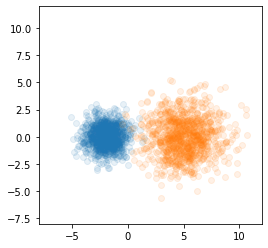

In [ ]:
G1 = utils.Gaussian_distribution(np.array([-2,0]),1, 2)
G2 = utils.Gaussian_distribution(np.array([5,0]),3, 2)


source_train = G1.generate_gaussian()
target_train = G2.generate_gaussian()

Train_loader_gaussian = torch.utils.data.DataLoader(source_train,batch_size=len(source_train))

plt.figure(figsize=[4,4])
plt.scatter(source_train[:,0],source_train[:,1],alpha=0.1)
plt.scatter(target_train[:,0],target_train[:,1],alpha=0.1)
plt.xlim(-8,12)
plt.ylim(-8,12)

GT_wdist = brenier.get_wdist(torch.tensor(source_train),torch.tensor(target_train))
print(f"The ground truth W_dist is {GT_wdist}")

In [ ]:
lse1 = brenier.LSE(2,500)
model_lse = brenier.c_transform(torch.tensor(target_train).float().to(device),lse1)
optimizer = torch.optim.Adam(model_lse.parameters(),0.004,[0.9,0.9],1e-6)
brenier.LSE_train(model_lse, device, Train_loader_gaussian, optimizer, 2001)
LSE_result =model_lse.transport(torch.tensor(source_train).float().to(device)).data.cpu()

0 tensor(9.0074, device='cuda:0')
500 tensor(16.9185, device='cuda:0')
1000 tensor(22.3738, device='cuda:0')
1500 tensor(24.7449, device='cuda:0')
2000 tensor(24.9754, device='cuda:0')


In [ ]:
icnn1 = brenier.ICNN(input_dim=2)
model_icnn1 = brenier.c_transform(torch.tensor(target_train).float().to(device),icnn1)
optimizer = torch.optim.Adam(model_icnn1.parameters(),0.004,[0.9,0.9],1e-6)
brenier.ICNN_train(model_icnn1, device, Train_loader_gaussian, optimizer, 301)
ICNN_result =model_icnn1.transport(torch.tensor(source_train).float().to(device)).data.cpu()

0 tensor(10.6276, device='cuda:0')
100 tensor(24.9862, device='cuda:0')
200 tensor(24.9915, device='cuda:0')
300 tensor(24.9922, device='cuda:0')


In [ ]:
icnn2 = brenier.ICNN(2)
model_icnn2 = brenier.c_transform(torch.tensor(target_train).float().to(device),icnn2)
optimizer2 = torch.optim.Adam(model_icnn2.parameters(),0.004,[0.9,0.9],1e-6)

brenier.mix_train(model_icnn2,device, Train_loader_gaussian, optimizer2, 500,alpha=0.1)
mix_result =model_icnn2.transport(torch.tensor(source_train).float().to(device)).data.cpu()

0 tensor(31.9142, device='cuda:0') tensor(10.7154, device='cuda:0')
100 tensor(0.0908, device='cuda:0') tensor(24.9865, device='cuda:0')
200 tensor(0.0764, device='cuda:0') tensor(24.9902, device='cuda:0')
300 tensor(0.0798, device='cuda:0') tensor(24.9890, device='cuda:0')
400 tensor(0.0738, device='cuda:0') tensor(24.9917, device='cuda:0')


In [ ]:
mlp1 = brenier.MLP(2)
optimizer = torch.optim.Adam(mlp1.parameters(),0.004,[0.9,0.9],1e-6)
brenier.MLP_train(mlp1, device, Train_loader_gaussian, torch.tensor(target_train).float().to(device) ,optimizer, 301)
MLP_result =mlp1(torch.tensor(source_train).float().to(device)).data.cpu()

In [ ]:
def plot_contour(ax,c_transform_model,x_lim,y_lim,source,target,result,title):

  xlist = np.linspace(x_lim[0], x_lim[1], 100)
  ylist = np.linspace(y_lim[0], y_lim[1], 100)
  X, Y = np.meshgrid(xlist, ylist)
  cord = np.concatenate([X.reshape(-1,1),Y.reshape(-1,1)],axis = 1)

  Z = c_transform_model.phi_Brenier(torch.tensor(cord).float().to(device)).data.cpu().reshape(X.shape)  
  cp = ax.contourf(X, Y, Z,cmap='gray')
  
  #fig.colorbar(cp) # Add a colorbar to a plot

  ax.set_title(title)

  ax.scatter(source[:,0],source[:,1],alpha = 0.25)
  ax.scatter(target[:,0],target[:,1],alpha = 0.25)
  ax.scatter(result[:,0],result[:,1],alpha = 0.25)

  return ax

In [ ]:
assert G1.dim == G2.dim
W = np.diag(np.ones(G1.dim)*G2.std/G1.std)**0.5
GT_result = (source_train-G1.mean)@W + G2.mean

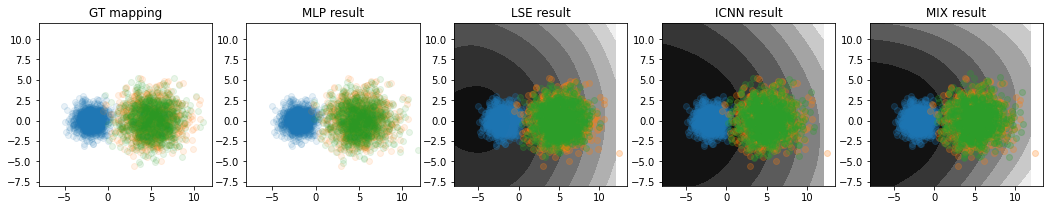

In [ ]:
fig,ax = plt.subplots(1,5,figsize = [18,3])


ax[0].set_xlim(-8,12)
ax[0].set_ylim(-8,12)
ax[0].set_title("GT mapping")
ax[0].scatter(source_train[:,0],source_train[:,1],alpha=0.1)
ax[0].scatter(target_train[:,0],target_train[:,1],alpha=0.1)
ax[0].scatter(GT_result[:,0],GT_result[:,1],alpha=0.1)

ax[1].set_xlim(-8,12)
ax[1].set_ylim(-8,12)
ax[1].set_title("MLP result")
ax[1].scatter(source_train[:,0],source_train[:,1],alpha=0.1)
ax[1].scatter(target_train[:,0],target_train[:,1],alpha=0.1)
ax[1].scatter(MLP_result[:,0],MLP_result[:,1],alpha=0.1)


ax[2]=plot_contour(ax[2],model_lse,[-8,12],[-8,12],source_train,target_train,LSE_result,'LSE result')

ax[3]=plot_contour(ax[3],model_icnn1,[-8,12],[-8,12],source_train,target_train,ICNN_result,'ICNN result')

ax[4]=plot_contour(ax[4],model_icnn2,[-8,12],[-8,12],source_train,target_train,mix_result,'MIX result')


In [ ]:
mlp_mse = ((MLP_result-GT_result)**2).mean()
lse_mse = ((LSE_result-GT_result)**2).mean()
icnn_mse = ((ICNN_result-GT_result)**2).mean()
mix_mse = ((mix_result-GT_result)**2).mean()

print("mlp_mse",mlp_mse)
print("lse_mse",lse_mse)
print("icnn_mse",icnn_mse)
print("mix_mse",mix_mse)

mlp_mse tensor(0.0308, dtype=torch.float64)
lse_mse tensor(0.0249, dtype=torch.float64)
icnn_mse tensor(0.0299, dtype=torch.float64)
mix_mse tensor(0.0335, dtype=torch.float64)


In [ ]:
n_sample = [20,50,100,200,500,1000]
dim = [1,2,5,10,20,50,100,200,500]

len_n = len(n_sample)
len_d = len(dim)

In [ ]:
icnn_mse = np.zeros([len_d,len_n])
mlp_mse = np.zeros([len_d,len_n])
lse_mse = np.zeros([len_d,len_n])
mix_mse = np.zeros([len_d,len_n])

In [ ]:
it = 5

for i in range(len_d):
  for j in range(len_n):
    for _ in range(it):
      # generate Gaussian
      G1 = utils.Gaussian_distribution(np.zeros(dim[i]),1, dim[i])
      G2 = utils.Gaussian_distribution(np.ones(dim[i]),3, dim[i])

      source_train = G1.generate_gaussian(n_sample=n_sample[j])
      target_train = G2.generate_gaussian(n_sample=n_sample[j])

      assert G1.dim == G2.dim
      W = np.diag(np.ones(G1.dim)*G2.std/G1.std)**0.5
      GT_result = (source_train-G1.mean)@W + G2.mean

      Train_loader_gaussian = torch.utils.data.DataLoader(source_train,batch_size=len(source_train))

      # ICNN train
      icnn1 = brenier.ICNN(dim[i])
      model_icnn = brenier.c_transform(torch.tensor(target_train).float().to(device),icnn1)
      optimizer = torch.optim.Adam(model_icnn.parameters(),0.004,[0.9,0.9],1e-6)
      brenier.ICNN_train(model_icnn, device, Train_loader_gaussian, optimizer, 501,print_bool=False)
      ICNN_result =model_icnn.transport(torch.tensor(source_train).float().to(device)).data.cpu()
      icnn_mse[i,j] += ((ICNN_result-GT_result)**2).mean()/it

      # MLP train
      mlp1 = brenier.MLP(dim[i])
      optimizer = torch.optim.Adam(mlp1.parameters(),0.004,[0.9,0.9],1e-6)
      brenier.MLP_train(mlp1, device,Train_loader_gaussian, torch.tensor(target_train).float().to(device) ,optimizer, 501,print_bool=False)
      MLP_result =mlp1(torch.tensor(source_train).float().to(device)).data.cpu()
      mlp_mse[i,j] += ((MLP_result-GT_result)**2).mean()/it

      # LSE train

      lse1 = brenier.LSE(dim[i],100)
      model_lse = brenier.c_transform(torch.tensor(target_train).float().to(device),lse1).to(device)
      optimizer = torch.optim.Adam(model_lse.parameters(),0.004,[0.9,0.9],2e-6)
      brenier.LSE_train(model_lse, device, Train_loader_gaussian, optimizer, 501,print_bool=False)
      LSE_result =model_lse.transport(torch.tensor(source_train).float().to(device)).data.cpu()
      lse_mse[i,j] += ((LSE_result-GT_result)**2).mean()/it


    print(f"(dim,n_sample)=({dim[i]},{n_sample[j]}),icnn_mse={'%6.3f'%icnn_mse[i,j]},mlp_mse={'%6.3f'%mlp_mse[i,j]},lse_mse={'%6.3f'%lse_mse[i,j]}")

(dim,n_sample)=(1,20),icnn_mse= 1.641,mlp_mse= 1.906,lse_mse= 1.459
(dim,n_sample)=(1,50),icnn_mse= 0.313,mlp_mse= 0.343,lse_mse= 0.220
(dim,n_sample)=(1,100),icnn_mse= 0.482,mlp_mse= 0.461,lse_mse= 0.368
(dim,n_sample)=(1,200),icnn_mse= 0.258,mlp_mse= 0.243,lse_mse= 0.188
(dim,n_sample)=(1,500),icnn_mse= 0.045,mlp_mse= 0.040,lse_mse= 0.031
(dim,n_sample)=(1,1000),icnn_mse= 0.034,mlp_mse= 0.036,lse_mse= 0.026
(dim,n_sample)=(2,20),icnn_mse= 2.137,mlp_mse= 2.391,lse_mse= 1.178
(dim,n_sample)=(2,50),icnn_mse= 0.882,mlp_mse= 1.251,lse_mse= 0.636
(dim,n_sample)=(2,100),icnn_mse= 0.426,mlp_mse= 0.613,lse_mse= 0.223
(dim,n_sample)=(2,200),icnn_mse= 0.216,mlp_mse= 0.310,lse_mse= 0.132
(dim,n_sample)=(2,500),icnn_mse= 0.146,mlp_mse= 0.165,lse_mse= 0.092
(dim,n_sample)=(2,1000),icnn_mse= 0.081,mlp_mse= 0.080,lse_mse= 0.044
(dim,n_sample)=(5,20),icnn_mse= 2.966,mlp_mse= 4.537,lse_mse= 1.169
(dim,n_sample)=(5,50),icnn_mse= 0.760,mlp_mse= 1.606,lse_mse= 0.398
(dim,n_sample)=(5,100),icnn_mse= 0.421

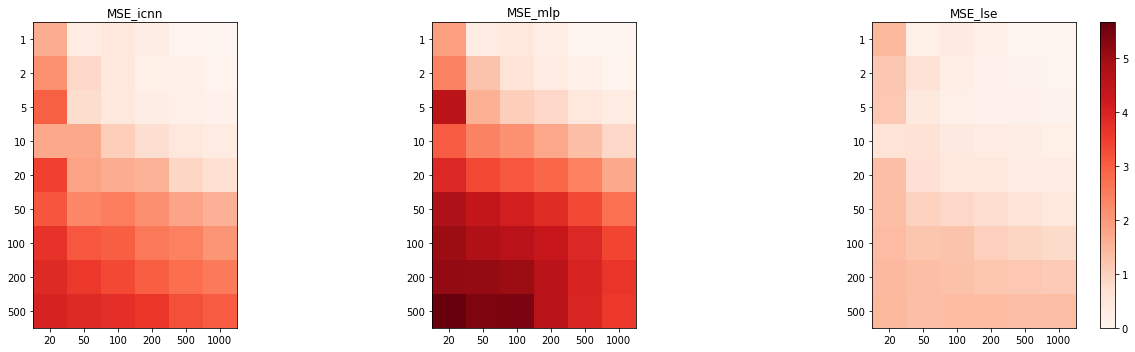

In [ ]:
fig, ax = plt.subplots(1,3,figsize=[18,5])
vmax = max(icnn_mse.max(),mlp_mse.max(),lse_mse.max())
# icnn result
img0 = ax[0].imshow(icnn_mse,cmap='Reds',vmax= vmax,vmin=0)
ax[0].set_xticks(np.arange(len(n_sample)))
ax[0].set_xticklabels(n_sample)
ax[0].set_yticks(np.arange(len(dim)))
ax[0].set_yticklabels(dim)
ax[0].set_title("MSE_icnn")
# mpl result
img1 = ax[1].imshow(mlp_mse,cmap='Reds',vmax= vmax,vmin=0)
ax[1].set_xticks(np.arange(len(n_sample)))
ax[1].set_xticklabels(n_sample)
ax[1].set_yticks(np.arange(len(dim)))
ax[1].set_yticklabels(dim)
ax[1].set_title("MSE_mlp")
# lse result
img2 = ax[2].imshow(lse_mse,cmap='Reds',vmax= vmax,vmin=0)
ax[2].set_xticks(np.arange(len(n_sample)))
ax[2].set_xticklabels(n_sample)
ax[2].set_yticks(np.arange(len(dim)))
ax[2].set_yticklabels(dim)
ax[2].set_title("MSE_lse")
fig.tight_layout()

fig.colorbar(img1)

In [ ]:
mlp_mse = np.round(mlp_mse,3)
np.savetxt("mlp.csv", mlp_mse, delimiter=",")

lse_mse=np.round(lse_mse,3)
np.savetxt("lse.csv", lse_mse, delimiter=",")

icnn_mse=np.round(icnn_mse,3)
np.savetxt("icnn.csv", icnn_mse, delimiter=",")

two moon

In [ ]:
moon = utils.TwoMoon()
source_train = moon.source_train
target_train = moon.target_train
source_test  = moon.source_test
target_test  = moon.target_test

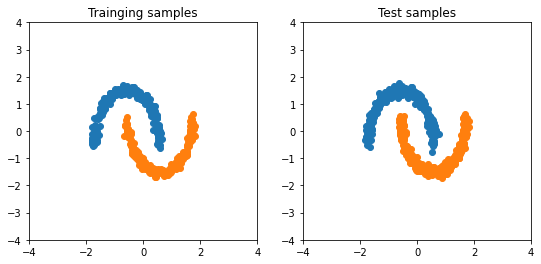

In [ ]:
fig,ax = plt.subplots(1,2,figsize = [9,4])

ax[0].set_xlim(-4,4)
ax[0].set_ylim(-4,4)
ax[0].set_title("Trainging samples")
ax[0].scatter(source_train[:,0],source_train[:,1])
ax[0].scatter(target_train[:,0],target_train[:,1])

ax[1].set_xlim(-4,4)
ax[1].set_ylim(-4,4)
ax[1].set_title("Test samples")
ax[1].scatter(source_test[:,0],source_test[:,1])
ax[1].scatter(target_test[:,0],target_test[:,1])

In [ ]:
Train_loader_moon = torch.utils.data.DataLoader(source_train,batch_size=len(source_train))

lse1 = brenier.LSE(2,500,alpha=0.5)
model_lse = brenier.c_transform(torch.tensor(target_train).float().to(device),lse1)

optimizer = torch.optim.Adam(model_lse.parameters(),0.004,[0.9,0.9],1e-6)
brenier.LSE_train(model_lse, device, Train_loader_moon, optimizer, 2001)
LSE_result =model_lse.transport(torch.tensor(source_train).float().to(device)).data.cpu()

0 tensor(0.3433, device='cuda:0')
500 tensor(1.8911, device='cuda:0')
1000 tensor(1.9007, device='cuda:0')
1500 tensor(1.9034, device='cuda:0')
2000 tensor(1.9040, device='cuda:0')


In [ ]:
Train_loader_moon = torch.utils.data.DataLoader(source_train,batch_size=len(source_train))

icnn1 = brenier.ICNN(2)
model_icnn1 = brenier.c_transform(torch.tensor(target_train).float().to(device),icnn1)
optimizer = torch.optim.Adam(model_icnn1.parameters(),0.004,[0.9,0.9],1e-6)
brenier.ICNN_train(model_icnn1, device, Train_loader_moon, optimizer, 301)
ICNN_result =model_icnn1.transport(torch.tensor(source_train).float().to(device)).data.cpu()

0 tensor(1.0458, device='cuda:0')
100 tensor(2.0048, device='cuda:0')
200 tensor(2.0072, device='cuda:0')
300 tensor(2.0073, device='cuda:0')


In [ ]:
icnn2 = brenier.ICNN(2)
model_icnn2 = brenier.c_transform(torch.tensor(target_train).float().to(device),icnn2)
optimizer2 = torch.optim.Adam(model_icnn2.parameters(),0.004,[0.9,0.9],1e-6)

brenier.mix_train(model_icnn2,device, Train_loader_moon, optimizer2, 500,alpha=0.15)
mix_result =model_icnn2.transport(torch.tensor(source_train).float().to(device)).data.cpu()

0 tensor(2.3484, device='cuda:0') tensor(0.5644, device='cuda:0')
100 tensor(0.0369, device='cuda:0') tensor(2.0043, device='cuda:0')
200 tensor(0.0194, device='cuda:0') tensor(2.0073, device='cuda:0')
300 tensor(0.0191, device='cuda:0') tensor(2.0071, device='cuda:0')
400 tensor(0.0216, device='cuda:0') tensor(2.0077, device='cuda:0')


In [ ]:
mlp1 = brenier.MLP(2)
optimizer = torch.optim.Adam(mlp1.parameters(),0.004,[0.9,0.9],1e-6)
brenier.MLP_train(mlp1, device, Train_loader_moon, torch.tensor(target_train).float().to(device) ,optimizer, 301)
MLP_result =mlp1(torch.tensor(source_train).float().to(device)).data.cpu()

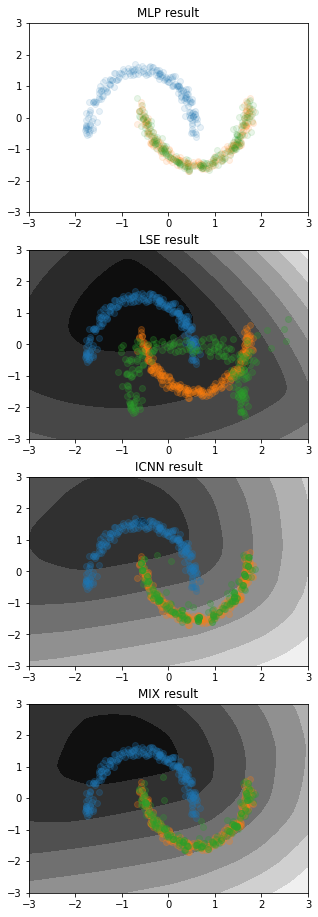

In [ ]:
fig,ax = plt.subplots(4,1,figsize = [5,16])


ax[0].set_xlim(-3,3)
ax[0].set_ylim(-3,3)
ax[0].set_title("MLP result")
ax[0].scatter(source_train[:,0],source_train[:,1],alpha=0.1)
ax[0].scatter(target_train[:,0],target_train[:,1],alpha=0.1)
ax[0].scatter(MLP_result[:,0],MLP_result[:,1],alpha=0.1)


ax[1]=plot_contour(ax[1],model_lse,[-3,3],[-3,3],source_train,target_train,LSE_result,'LSE result')

ax[2]=plot_contour(ax[2],model_icnn1,[-3,3],[-3,3],source_train,target_train,ICNN_result,'ICNN result')

ax[3]=plot_contour(ax[3],model_icnn2,[-3,3],[-3,3],source_train,target_train,mix_result,'MIX result')


lse Test

In [ ]:
alpha_value = np.linspace(-1, 1, 100)

for i,temp_alpha in enumerate(alpha_value):

  
  temp_lse = brenier.LSE(2,500,alpha=temp_alpha)
  temp_model_lse = brenier.c_transform(torch.tensor(target_train).float().to(device),temp_lse)

  optimizer = torch.optim.Adam(temp_model_lse.parameters(),0.004,[0.9,0.9],1e-6)
  brenier.LSE_train(temp_model_lse, device, Train_loader_moon, optimizer, 2001,print_bool = False)
  LSE_result =temp_model_lse.transport(torch.tensor(source_train).float().to(device)).data.cpu()

  fig,ax = plt.subplots(1,1,figsize = [5,4])
  ax = plot_contour(ax,temp_model_lse,[-3,3],[-3,3],source_train,target_train,LSE_result,f'alpha is {temp_alpha.round(3)}')
  plt.savefig(f"{i}.png")
  plt.close()



In [ ]:
with imageio.get_writer("sample_data/moon.gif", mode="I") as writer:
  for i,temp_alpha in enumerate(alpha_value):
            image = imageio.imread(f"{i}.png")
            writer.append_data(image)
            os.remove(f"{i}.png")